<a href="https://colab.research.google.com/github/Pratham34/Tensorflow-Deep-Learning-notebooks/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning with TensorFlow Part 1: Feature Extraction
    
Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

In [ ]:
# Are we using a GPU ?
!nvidia-smi

Tue Jan 24 17:23:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [ ]:
# Get data (10% of 10 food classes from Food101) - https://www.kaggle.com/dansbecker/food-101 
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-01-24 17:24:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.7MB/s    in 8.0s    

2023-01-24 17:24:09 (20.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder ?
import os

# Walk through 10 percent data directory and list number of files
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting Up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime 

# We're creating a tensorBoard callback to track our model's training results , so that we could later compare them using tensorflow.dev

def create_tensorboard_callback(dir_name,experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

> 🔑 Note: You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The log_dir parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majroity of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# Let's compare the following two models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [ ]:
# Let's create a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
    """
     Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

      Args:
        model_url (str): A TensorFlow Hub feature extraction URL.
        num_classes (int): Number of output neurons in the output layer,
          should be equal to number of target classes, default 10.

      Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor
        layer and Dense output layer with num_classes output neurons.
    """
    
    # because we've set trainable = False , our feature extractor layer is not trainable during training.
    
    # Download the pretrained model and save it as a keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,     # Freeze the already learnt patterns
                                             name="feature_extraction_layer",
                                             input_shape=IMAGE_SHAPE+(3,))       
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes,activation="softmax",name="output_layer")
    ])
    
    return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create ResNet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2"
                                                                         )])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230124-172424
Epoch 1/5
24/24 [==============================] - 36s 1s/step - loss: 1.9740 - accuracy: 0.3520 - val_loss: 1.1765 - val_accuracy: 0.6264
Epoch 2/5
24/24 [==============================] - 15s 639ms/step - loss: 0.9138 - accuracy: 0.7307 - val_loss: 0.8521 - val_accuracy: 0.7288
Epoch 3/5
24/24 [==============================] - 15s 640ms/step - loss: 0.6228 - accuracy: 0.8320 - val_loss: 0.7497 - val_accuracy: 0.7632
Epoch 4/5
24/24 [==============================] - 15s 641ms/step - loss: 0.4737 - accuracy: 0.8813 - val_loss: 0.7101 - val_accuracy: 0.7692
Epoch 5/5
24/24 [==============================] - 15s 640ms/step - loss: 0.3765 - accuracy: 0.9160 - val_loss: 0.6787 - val_accuracy: 0.7800


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

Transfer Learning performs really good with less data because it's using the patterns that it's pre-learned on other problems.

In [ ]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
# and could do something like - from helper import plot_loss_curves

import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

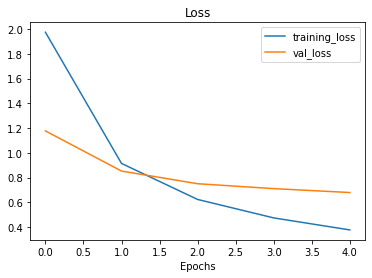

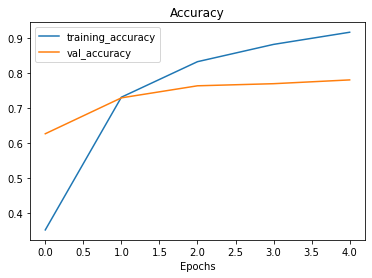

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# Create EfficientNetB0 feature extractor model - details on EfficientNet: https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html#:~:text=E
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)


# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230124-172613
Epoch 1/5
24/24 [==============================] - 24s 676ms/step - loss: 1.7900 - accuracy: 0.4813 - val_loss: 1.2534 - val_accuracy: 0.7600
Epoch 2/5
24/24 [==============================] - 14s 607ms/step - loss: 1.0242 - accuracy: 0.8067 - val_loss: 0.8499 - val_accuracy: 0.8280
Epoch 3/5
24/24 [==============================] - 14s 607ms/step - loss: 0.7379 - accuracy: 0.8480 - val_loss: 0.6894 - val_accuracy: 0.8488
Epoch 4/5
24/24 [==============================] - 14s 614ms/step - loss: 0.5911 - accuracy: 0.8733 - val_loss: 0.6038 - val_accuracy: 0.8576
Epoch 5/5
24/24 [==============================] - 14s 615ms/step - loss: 0.4998 - accuracy: 0.8920 - val_loss: 0.5500 - val_accuracy: 0.8640


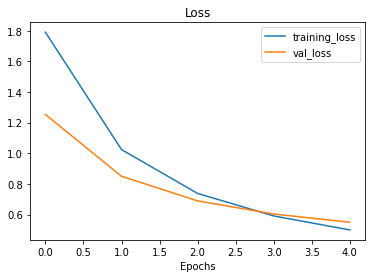

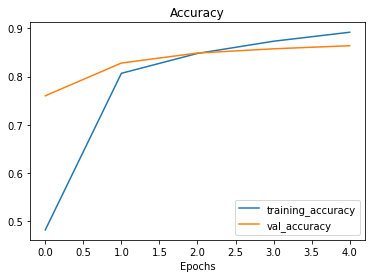

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# How many layers does our efficientnetb0 feature extractor have ?
# efficientnet_model.layers
# efficientnet_model.layers[0]
# efficientnet_model.layers[0].weights
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

So that's the major difference between fine tuning and feature extraction, is that in feature extraction, all of the layers generally stay 
frozen except for the output layer, whereas in fine tuning, we might unfreeze some of the underlying layers and update their parameters or 
weights with our own custom data set.
However, As with feature extraction, these layers start off with the patterns they've learned in ImageNet 

## Comparing our models results using TensorBoard

> 🔑 **Note:** When you upload things to TensorBoard.dev, you experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot

  # Hiding(Clearing) this code's output coz it's got our account's code in it !!

Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/Je02RqldRfaHNkND6KvSXQ/

Remember : The loss value is how wrong your model is , compared to ideal predictions that it should be making.

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/Je02RqldRfaHNkND6KvSXQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   Je02RqldRfaHNkND6KvSXQ
	Created              2023-01-24 17:35:26 (11 minutes ago)
	Updated              2023-01-24 17:35:31 (11 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918466
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id Je02RqldRfaHNkND6KvSXQ

In [ ]:
# Confirm the deletion by re-checking what experiments you have left
# !tensorboard dev list

"state of the art" meaning - (eg . like in this course its used a lot like - "state of the art" ml model)

Most recent stage of a product using the newest technology/research.
Thus leading to better results